***Задание:*** Решить краевую задачу для *дифференциального уравнения эллиптического типа*. Аппроксимацию уравнения произвести с использованием *центрально-разностной схемы*. Для решения дискретного аналога применить следующие методы: *метод простых итераций (метод Либмана), метод Зейделя, метод простых итераций с верхней релаксацией*. В различные моменты времени вычислить погрешность численного решения путем сравнения результатов с приведенным в задании аналитическим решением $u(x, t)$. Исследовать зависимость погрешности от сеточных параметров $\tau$ и $h$.

In [1]:
from ipywidgets import interact
from IPython.display import display
import random
import matplotlib.pyplot as plt
import math
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

***Уравнение:***

$$\displaystyle\frac{\partial^2 u}{\partial x^2} +  \displaystyle\frac{\partial^2 u}{\partial y^2} = 0 $$

\begin{equation*}
 \begin{cases}
   u_{x}' (0, \: y) = \phi_0(y) = e^y
   \\
   u_{x}' (\pi, \: y) = \phi_1(y) = -e^y
   \\
   u(x, \: 0) = \psi_0(x) = \sin{x}
   \\
   u(x, 1) = \psi_1(x) = e \sin{x}
 \end{cases}
\end{equation*}

***Аналитическое решение:***
$$u(x, t) = e^{y} \sin{x}$$

Будем решать задачу на заданном промежутке  от $0$ до $l_x$ по координате $x$ и на промежутке от $0$ до $l_y$ по координате $y$.

Рассмотрим конечно-разностную схему решения краевой задачи на сетке с граничными парамерами $l_x$, $l_y$ и параметрами насыщенности сетки $N_x$, $N_y$. Тогда размер шага по каждой из координат определяется:
$$h_x = \displaystyle\frac{l_x}{N_x - 1}, \; h_y = \displaystyle\frac{N_y}{N_y - 1}$$

Попробуем определить связь между дискретными значениями функции путем разностной апроксимации производной:

$$\displaystyle\frac{\partial^2 u}{\partial x^2}(x_j, y_i) + \displaystyle\frac{\partial^2 u}{\partial y^2}(x_j, y_i) = \displaystyle\frac{u_{j-1, i} - 2u_{j, i} + u_{j+1, i}}{h_x^2} + \displaystyle\frac{u_{j, i-1} - 2u_{j, i} + u_{j, i+1}}{h_y^2}$$

Тогда выражая из искомого уравнения значение
$u_{i, j} = \displaystyle\frac{h^2_y (u_{j-1, i} + u_{j+1, i}) + h^2_x (u_{j, i-1} + u_{j, i+1})}{2(h^2_x + h^2_y)}$, мы получаем основу для применения иттерационных методов решения *СЛАУ*.

Для расчета $u_{j, 0}$ и $u_{0, i}$ следует использовать граничные условия.

Поскольку в нашем варианте известны граничные значения $u(x, l_{y0})$ и $u(x, l_{y1})$, то для начальной инициаизации значений в сетке можно использовать линейную интерполяцию при фиксированном $x = x_j$ для улучшения сходимости:

$$u_{j, i} = \frac{u(x_j, l_{y1}) - u(x_j, l_{y0})}{l_{y1} - l_{y0}} \cdot (y_i - l_{y0}) + u(x_j, l_{y0})$$

Для границ по $y$ координате значения заданы явно граничным условием, и мы можем определить их на начальном этапе при инициализации.

Для границ по $x$ координате аппроксимируем значение производной из граничного условия с помощью трёхточечной аппроксимации в точках $x = 0$ и $x = l$ и получаем 2 новых уравнения в *СЛАУ* соответственно:

$$\displaystyle\frac{-3u_{0, i} + 4u_{1, i} - u_{2, i}}{2h_x} = \phi_0(y_i)$$

$$\displaystyle\frac{3u_{N, i} - 4u_{N-1, i} + u_{N-2, i}}{2h_x} = \phi_1(y_i)$$

Тогда основа для иттерационного метода:

$$u_{0, i} = \displaystyle\frac{-2h_x \phi_0(y_i) + 4u_{1, i} - u_{2, i}}{3}$$

$$u_{N, i} = \displaystyle\frac{2h_x \phi_1(y_i) + 4u_{N-1, i} - u_{N-2, i}}{3}$$

Для решения СЛАУ можно воспользоваться иттерационными методами, такими как *метод простых иттераций, метод Зейделя* и *метод верхних релаксаций*. Первые два метода были изучены нами ранее, когда как последний является небольшой модификацией *метода Зейделя* с добавлением параметра *w*, который позволяет регулировать скорость сходимости метода.

In [2]:
# analytic solve
def u(x, y):
    return math.exp(y)*math.sin(x)

In [3]:
# class will return grid of values
class Schema:
    def __init__(self, solver="zeidel", relax=0.1, epsilon = 0.01):
        
        self.psi0 = lambda x: math.sin(x)
        self.psi1 = lambda x: math.sin(x) * math.e
        
        self.phi0 = lambda y: math.exp(y)
        self.phi1 = lambda y: -math.exp(y)
        
        self.lx0, self.lx1 = 0, math.pi
        self.ly0, self.ly1 = 0, 1
        
        self.eps = epsilon
        self.method = None
        
        if solver == "zeidel":
            self.method = self.zeidel_step
        elif solver == "simple":
            self.method = self.simple_eiler_step
        elif solver == "relaxation":
            self.method = lambda x, y, m: self.relaxation_step(x, y, m, relax)
        else:
            raise ValueError("Wrong solver name")
        
        
    def zeidel_step(self, X, Y, M):
        return self.relaxation_step(X, Y, M, w=1)
    
    def relaxation_step(self, X, Y, M, w):
        # norm of diffrance between value matrixes
        norm = 0.0
        hx2 = self.hx * self.hx
        hy2 = self.hy * self.hy
        
        for i in range(1, self.Ny - 1):
            # compute from first equation
            diff = w*((-2*self.hx*self.phi0(Y[i][0]) + 4*M[i][1] - M[i][2])/3 - M[i][0])
            M[i][0] += diff
            # diff between last and now mtrx
            diff = abs(diff)
            norm = diff if diff > norm else norm
            # compute inner equation
            for j in range(1, self.Nx - 1):
                diff = hy2*(M[i][j-1] + M[i][j+1])
                diff += hx2*(M[i-1][j] + M[i+1][j])
                diff /= 2*(hy2 + hx2)
                diff -= M[i][j]
                diff *= w
                M[i][j] += diff
                # compute elements diff
                diff = abs(diff)
                norm = diff if diff > norm else norm
            # compute from last equation
            diff = w*((2*self.hx*self.phi1(Y[i][-1]) + 4*M[i][-2] - M[i][-3])/3 - M[i][-1])
            M[i][-1] += diff
            # diff between last and now mtrx
            diff = abs(diff)
            norm = diff if diff > norm else norm
            
        return norm
    
    def simple_eiler_step(self, X, Y, M):
        temp = [[0.0 for _ in range(self.Nx)] for _ in range(self.Ny)]
        # norm of diffrance between value matrixes
        norm = 0.0
        hx2 = self.hx * self.hx
        hy2 = self.hy * self.hy
        
        for i in range(1, self.Ny - 1):
            # compute from first equation
            temp[i][0] = (-2*self.hx*self.phi0(Y[i][0]) + 4*M[i][1] - M[i][2]) / 3
            # diff between last and now mtrx
            diff = abs(temp[i][0] - M[i][0])
            norm = diff if diff > norm else norm
            # compute inner equation
            for j in range(1, self.Nx - 1):
                temp[i][j] = hy2*(M[i][j-1] + M[i][j+1])
                temp[i][j] += hx2*(M[i-1][j] + M[i+1][j])
                temp[i][j] /= 2*(hy2 + hx2)
                # compute elements diff
                diff = abs(temp[i][j] - M[i][j])
                norm = diff if diff > norm else norm
            # compute from last equation
            temp[i][-1] = (2*self.hx*self.phi1(Y[i][-1]) + 4*M[i][-2] - M[i][-3]) / 3
            # diff between last and now mtrx
            diff = abs(temp[i][0] - M[i][0])
            norm = diff if diff > norm else norm
            
        # move data from temp to main matrix
        for i in range(1, self.Ny - 1):
            M[i] = temp[i]
            
        return norm
    
    def _compute_h(self):
        self.hx = (self.lx1 - self.lx0) / (self.Nx - 1)
        self.hy = (self.ly1 - self.ly0) / (self.Ny - 1)
    
      
    @staticmethod
    def nparange(start, end, step = 1):
        now = start
        e = 0.00000000001
        while now - e <= end:
            yield now
            now += step
            
    # linear interpolation init
    def init_values(self, X, Y):
        ans = [[0 for _ in range(self.Nx)] for _ in range(self.Ny)]
        for j in range(self.Nx):
            coeff = (self.psi1(X[-1][j]) - self.psi0(X[0][j])) / (self.ly1 - self.ly0)
            addition = self.psi0(X[0][j])
            for i in range(self.Ny):
                ans[i][j] = coeff*(Y[i][j] - self.ly0) + addition
        return ans

    
    def fit(self, Nx=10, Ny=10):
        # compute hx and hy
        self.Nx, self.Ny = Nx, Ny
        self._compute_h()

        # init grid:
        # compute x, y values:
        x = list(self.nparange(self.lx0, self.lx1, self.hx))
        y = list(self.nparange(self.ly0, self.ly1, self.hy))
        # grid
        X = [x for _ in range(self.Ny)]
        Y = [[y[i] for _ in x] for i in range(self.Ny)]
        # get first values of grid
        ans = self.init_values(X, Y)
        
        self.itters = 0
        
        while(self.method(X, Y, ans) >= self.eps):
            self.itters += 1
        
        return X, Y, ans

### Зависимость погрешности от параметра $h$

#### Вычисление погрешностей

In [4]:
def epsilon(x, y, z, f):
    ans = 0.0
    for i in range(len(z)):
        for j in range(len(z[i])):
            ans += (z[i][j] - f(x[i][j], y[i][j]))**2
    return (ans / (len(z) * len(z[0])))**0.5

Постоение зависимости погрешности от шага $h$.

In [5]:
def get_graphic_h(solver, real_f):
    h, e = [], []
    for N in range(4, 80, 3):
        x, y, z = solver.fit(N, N)
        h.append(solver.hx)
        e.append(epsilon(x, y, z, real_f))
    return h, e

#### График погрешностей

Построим график зависимости погрешности $\epsilon$ от размера шага $h_x$ по координате $x$, но уменьшать размер шага будем пропорционально уменьшению шага $h_y$ по координате $y$.

In [6]:
explict = Schema(epsilon=0.00001)

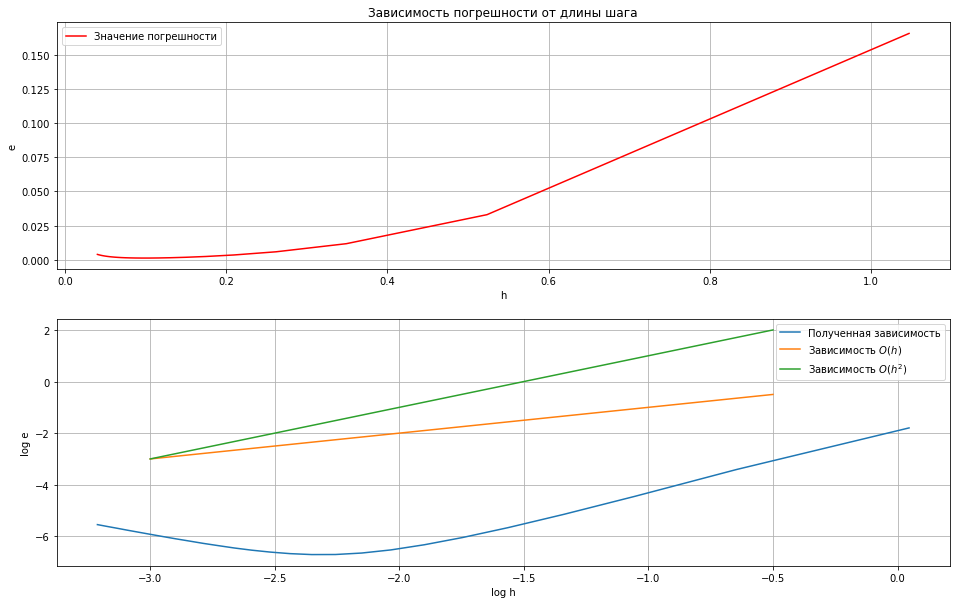

In [7]:
plt.figure(figsize = (16, 10))

plt.subplot(2, 1, 1)
plt.title("Зависимость погрешности от длины шага")
h, e = get_graphic_h(explict, u)

plt.plot(h, e, label="Значение погрешности", color = "red")
plt.xlabel("h")
plt.ylabel("e")
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(list(map(math.log, h)), list(map(math.log, e)), label="Полученная зависимость")
plt.plot([-3, -0.5], [-3, -0.5], label="Зависимость $O(h)$")
plt.plot([-3, -0.5], [-3, 2], label="Зависимость $O(h^2)$")
plt.xlabel("log h")
plt.ylabel("log e")

plt.legend()
plt.grid()

#### Сетка для реальной функции

In [8]:
def real_z(lx0, lx1, ly0, ly1, f):
    x = np.arange(lx0, lx1 + 0.005, 0.005)
    y = np.arange(ly0, ly1 + 0.005, 0.005)
    X = np.ones((y.shape[0], x.shape[0]))
    Y = np.ones((x.shape[0], y.shape[0]))
    Z = np.ones((y.shape[0], x.shape[0]))
    for i in range(Y.shape[0]):
        Y[i] = y
    Y = Y.T
    for i in range(X.shape[0]):
        X[i] = x
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            Z[i, j] = f(X[i, j], Y[i, j])
    return X, Y, Z

#### Трёхмерное представление

In [13]:
def plot_1(Nx = 5, Ny=5, eps=1, plot = False):
    schema = Schema(epsilon=eps, solver="simple", relax=1.3)
    x, y, z = schema.fit(Nx, Ny)
    fig = plt.figure(num=1, figsize=(19, 12), clear=True)
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    if plot:
        ax.plot_wireframe(*real_z(0, math.pi, 0, 1, u), color="green")
    ax.plot_surface(np.array(x), np.array(y), np.array(z))
    ax.set(xlabel='x', ylabel='y', zlabel='z', 
           title='График приближения и реальной функции конечно-разностным методом')
    fig.tight_layout()

epsilon = [1.0 / (10.0**n) for n in range(7)]
interact(plot_1, Nx=(5, 200, 2), Ny=(5, 200, 3), eps=epsilon,  plot_true = [False, True])
None

interactive(children=(IntSlider(value=5, description='Nx', max=200, min=5, step=2), IntSlider(value=5, descrip…

#### Сходимость методов

In [10]:
schema = Schema(epsilon=0.001, solver="simple")
schema.fit(10, 10)
f"Количество иттераций метода простых иттераций: {schema.itters}"

'Количество иттераций метода простых иттераций: 41'

In [11]:
schema = Schema(epsilon=0.001)
schema.fit(10, 10)
f"Количество иттераций метода Зейделя: {schema.itters}"

'Количество иттераций метода Зейделя: 27'

In [12]:
schema = Schema(epsilon=0.001, solver="relaxation", relax=1.5)
schema.fit(10, 10)
f"Количество иттераций метода релаксаций: {schema.itters}"

'Количество иттераций метода релаксаций: 13'